# Sprint20 ResNetとVGG

このサンプルコードのフォルダ・ファイル構成の前提は下記になります。

unet/

    ・・・・
    Sprint19.ipynb
    Sprint20.ipynb
    competition_data/
        train/
        test/
        depths.csv
    ・・・・
    
下記参考までに、詳細は各自調べてみてください。
    
resnet概要：https://www.bigdata-navi.com/aidrops/2611/

vgg概要：https://aizine.ai/glossary-vgg/

# ライブラリのimport

In [ ]:
!pip install h5py==2.10
!pip install keras==2.2
!pip install keras-applications==1.0.7
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
     |████████████████████████████████| 300 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account al

In [ ]:
#CPUかGPUの確認
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()


In [ ]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.losses import binary_crossentropy
from keras.applications.vgg19 import VGG19, preprocess_input

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

In [6]:
%pwd

'/content'

In [7]:
%ls

drive/  sample_data/


In [10]:
!content/drive/MyDrive/Colab Notebooks/Sprint19,20 U-net ,Resnet,VGG/unet-master

/bin/bash: content/drive/MyDrive/Colab: No such file or directory


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込みと深さ情報の付与

depths.csvに深さの情報が格納されているため、train.csvとsample_submission.csvに結合する。

＊rle_maskについての説明：https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/61955

In [30]:
# 各種読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('sample_submission.csv')
depth_df = pd.read_csv('depths.csv')

# 出力
display(train_df.head())
display(test_df.head())

# depths.csvと結合
train_df = train_df.merge(depth_df, how='left', on='id')
test_df = test_df.merge(depth_df, how='left', on='id')

# 出力
display(train_df.head())
display(test_df.head())

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


,id,rle_mask
0,155410d6fa,1 1
1,78b32781d1,1 1
2,63db2a476a,1 1
3,17bfcdb967,1 1
4,7ea0fd3c88,1 1


,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


,id,rle_mask,z
0,155410d6fa,1 1,559
1,78b32781d1,1 1,298
2,63db2a476a,1 1,392
3,17bfcdb967,1 1,698
4,7ea0fd3c88,1 1,837


# 画像データの読み込みとnumpy配列化

In [34]:
X_train = np.asarray(
    [cv2.imread('train/images/{}.png'.format(x), 0) for x in train_df.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread('train/masks/{}.png'.format(x), 0) for x in train_df.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


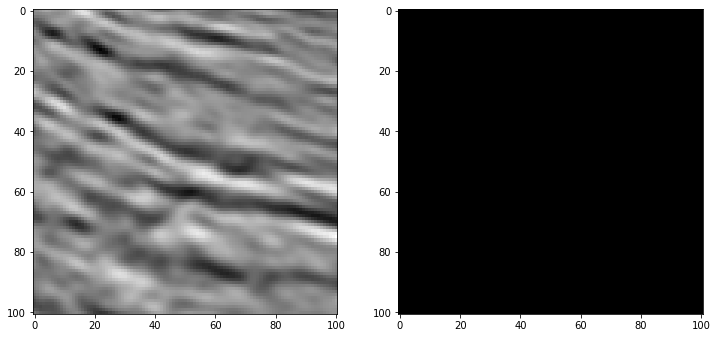

In [35]:
# 試しに描画
random_index = np.random.randint(0, X_train.shape[0])
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

# セグメンテーションされている領域割合計算

In [36]:
def compute_coverage(df, masks):
    """領域割合の計算とクラスの付与
    Parameters
    ------------
    train_df : df
    masks : セグメンテーション画像
    """
    def coverage_to_class(val):
        """領域割合からクラスを付与
        val : セグメンテーション領域の割合
        """
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # セグメンテーション領域の割合
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # 何割が覆われているかで、0~10までのクラスを与える
    df['coverage_class'] = df.coverage.map(coverage_to_class)

    return df

# 関数実行
compute_coverage(train_df, y_train)

# 出力
display(train_df)

,id,rle_mask,z,coverage,coverage_class
0,575d24d81d,NaN,843,0.000000,0
1,a266a2a9df,5051 5151,794,0.504950,6
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,0.993334,10
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,0.149201,2
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,0.042839,1
...,...,...,...,...,...
3995,9cbd5ddba4,NaN,218,0.000000,0
3996,caa039b231,2398 7 2499 11 2600 16 2700 22 2801 26 2901 29...,602,0.376924,4
3997,1306fcee4c,NaN,177,0.000000,0
3998,48d81e93d9,2828 1 2927 3 3026 5 3126 6 3225 8 3324 10 342...,221,0.482796,5


# データセットの準備

In [16]:
def create_depth_abs_channels(image_tensor):
    """3チャンネルに拡張
    """
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)
    return image_tensor

# 3チャンネルに拡張
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# ResNetのデフォルトのサイズに合わせるため、224,224にリサイズ
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))

# train_test_splitでもよさそうだが、、、
kfold = StratifiedKFold(n_splits=5)
for train_index, valid_index in kfold.split(train_df.id.values, train_df.coverage_class.values):
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    break
    
# セグメンテーションの正解データの形整える
y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_resized.shape, y_resized.shape)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

NameError: ignored

# 損失関数など定義

In [38]:
def dice_loss(y_true, y_pred):
    """dice損失の計算
    DICE損失参考：https://qiita.com/ppza53893/items/8090322792e1c7f81e57
    """
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    """binary_crossentropyとdice加算した統合損失
    """
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    """IOUの計算
    IOU参考：https://www.sigfoss.com/developer_blog/detail?actual_object_id=147
    A : 正解データ
    B : 0.5より大きければ1 0.5以下なら0に変換された予測領域
    """
    # バッチ数取得
    batch_size = A.shape[0]
    # 最終的な評価指標
    metric = 0.0
    # バッチ数でループ
    for batch in range(batch_size):
        # 引数A,Bより配列抽出
        t, p = A[batch], B[batch]
        # 正しい領域のピクセル
        true = np.sum(t) 
        # 推定した領域のピクセル
        pred = np.sum(p) 
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
            
        # 正しく領域と推定されたピクセル
        intersection = np.sum(t * p) 
        
        # IOU計算
        union = true + pred - intersection
        iou = intersection / union
        
        # 実際のIOUに近似
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        # 最終的な評価指標に加算
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

# resnet50モデルの定義

In [39]:
# 入力のshape定義
input_size = (224, 224, 3)

In [15]:
# ライブラリのimportの際に読み込んでおいたResNet50をインスタンス化
# 全結合層を場外する指定：include_top=False
base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

NameError: ignored

# デコーダーブロックの定義

エンコーダーとデコーダーに関して、下記参照

https://atmarkit.itmedia.co.jp/ait/articles/2007/10/news024.html

In [41]:
def decoder_block_simple(layer_name, block_name,num_filters=32,conv_dim=(3, 3)):
    """デコーダーブロック
    Parameters
    ------------
    layer_name : 前の層のインスタンス
    block_name : この層のベースとなる名前
    num_filters : フィルター数
    conv_dim : フィルターサイズ
    """
    # 畳み込み
    x_dec = Conv2D(num_filters, conv_dim,padding='same',name='{}_conv'.format(block_name))(layer_name)
    # バッチ正規化
    x_dec = BatchNormalization(name='{}_bn'.format(block_name))(x_dec)
    # 活性化関数（PReLU）
    x_dec = PReLU(name='{}_activation'.format(block_name))(x_dec)
    return x_dec


def decoder_block_bottleneck(layer_name, block_name,num_filters=32,conv_dim=(3, 3),dropout_frac=0.2):
    """複雑なデコーダーブロック
    Parameters
    ------------
    layer_name : 前の層のインスタンス
    block_name : この層のベースとなる名前
    num_filters : フィルター数
    conv_dim : フィルターサイズ
    dropout_frac : ドロップアウト率
    """
    x_dec = Conv2D(num_filters, conv_dim,padding='same',name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(num_filters // 2, conv_dim,padding='same',name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(num_filters, conv_dim,padding='same',name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])
    return x_dec2

# 全体モデルの定義

In [14]:
def unet_resnet(input_size, decoder_block,weights='imagenet',loss_func='binary_crossentropy',metrics_list=[my_iou_metric],use_lovash=False):
    """resnetを模倣したunet構造のネットワーク
    Parameters
    ------------
    input_size    : 入力サイズ
    decoder_block : デコーダーブロック
    weights       : 重みの初期値　        default:imagenet,
    loss_func     : 損失関数　            default:binary_crossentropy
    metrics_list  : 指標一覧　            default:[my_iou_metric]
    use_lovash    : lavash使うか          default:False
    """
    # resnet50のベースモデル
    base_model = ResNet50(input_shape=input_size, include_top=False, weights=weights)
    
    # base_modelの中間層を抽出
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40
    
    # 流れ
    # ①encoder5の出力をデコーダーブロックに渡す
    # ②encoder5と①を結合
    center = decoder_block(encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # 流れ
    # ①concat5,の出力をデコーダーブロックに渡す
    # ②①をupsamplingする
    # ③encoder4と②を結合する
    # ①～③を繰り返し
    decoder4 = decoder_block(concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # 再度upsamplingする
    output = UpSampling2D()(concat1)
    # デコーダーブロックに通す
    output = decoder_block(output, 'decoder_output', num_filters=32)
    # 畳込み
    output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        # lovash使う場合は、sigmoid関数に通しておく
        output = Activation('sigmoid')(output)
        
    
    # モデルの結合
    model = Model(base_model.input, output)
    # 損失・最適化手法・指標一覧を与えて、コンパイル
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)
    
    # モデルを返す
    return model

NameError: ignored

# 学習

【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

In [13]:
# モデルの定義
model = unet_resnet(input_size, decoder_block_bottleneck, weights='imagenet',loss_func=bce_dice_loss, metrics_list=[my_iou_metric],use_lovash=False)
print(model.summary())

NameError: ignored

In [17]:
# 学習回数
EPOCHS = 2
# バッチ数
BATCH_NUM = 16

# モデルの保存設定
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5',
    monitor='val_my_iou_metric',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
# 学習率の減衰設定
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1
)


# 学習の実行と学習過程の取得
history = model.fit(
    X_tr, y_tr,
    validation_data=[X_val, y_val], 
    epochs=EPOCHS,
    batch_size=BATCH_NUM,
    callbacks=[model_checkpoint,reduce_lr], 
    verbose=1
)

NameError: ignored

# 推定

In [2]:
# 推定
val_preds = model.predict(X_val, batch_size=16)

# 元の大きさにリサイズ
y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

NameError: ignored

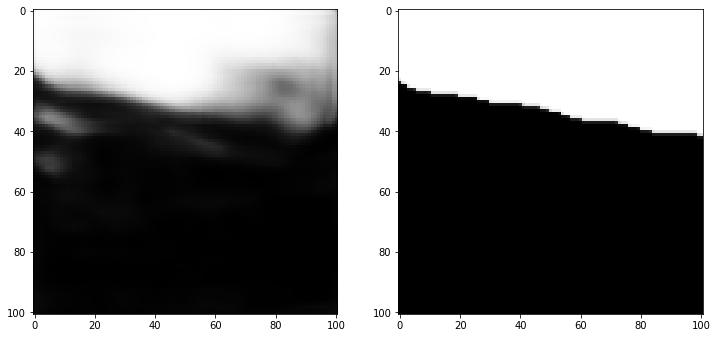

In [ ]:
# 描画
random_index = np.random.randint(0, y_val_pred.shape[0])
fig, ax = plt.subplots(1, 2)
ax[0].imshow(y_val_pred[random_index], cmap='gray')
ax[1].imshow(y_val_true[random_index], cmap='gray')

# 上記コードのVGG対応

In [ ]:
def unet_vgg(input_size, decoder_block,weights='imagenet',loss_func='binary_crossentropy',metrics_list=[my_iou_metric],use_lovash=False):
    """説明省略"""
    base_model = VGG19(input_shape=input_size, include_top=False,weights=weights)
    
    encoder1 = base_model.get_layer('block1_conv2').output # (224,224,64)
    encoder2 = base_model.get_layer('block2_conv2').output # (112,112,228)
    encoder3 = base_model.get_layer('block3_conv4').output # (56,56,256)
    encoder4 = base_model.get_layer('block4_conv4').output # (28,28,512)
    encoder5 = base_model.get_layer('block5_conv4').output # (14,14,512)


    center = decoder_block(encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1) # (14,14,1024)

    decoder4 = decoder_block(concat5, 'decoder4', num_filters=256) 
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1) 
    
    decoder3 = decoder_block(concat4, 'decoder3', num_filters=128) 
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1) 

    decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)
    
    output = decoder_block(concat1, 'decoder_output', num_filters=32)
    output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [ ]:
# モデルの定義
model = unet_vgg(input_size, decoder_block_bottleneck, weights='imagenet',loss_func=bce_dice_loss, metrics_list=[my_iou_metric],use_lovash=False)
print(model.summary())

In [ ]:
# 学習回数
EPOCHS = 2
# バッチ数
BATCH_NUM = 16

# モデルの保存設定
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5',
    monitor='val_my_iou_metric',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
# 学習率の減衰設定
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1
)


# 学習の実行と学習過程の取得
history = model.fit(
    X_tr, y_tr,
    validation_data=[X_val, y_val], 
    epochs=EPOCHS,
    batch_size=BATCH_NUM,
    callbacks=[model_checkpoint,reduce_lr], 
    verbose=1
)